Lesson 14

Author: Rodrigo MM Santiago @rodrigommsantiago

In [1]:
# Modules...
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting

# inline plotting
%matplotlib inline

# filter, Hilbert transform and spectrogram functions
from scipy.signal import butter,filtfilt,hilbert,spectrogram

# Z-Score function
from scipy.stats import zscore

# loading Matlab data
from scipy.io import loadmat

# Rayleigh "p" value function
from astropy.stats.circstats import rayleightest

Cross-frequency couplings:<br>
- phase-phase (n:m)<br>
- phase-amplitude<br>
- amplitude-amplitude<br>
- phase-frequency<br>
- frequency-frequency<br>
- amplitude-frequency<br>

n:m phase-locking:

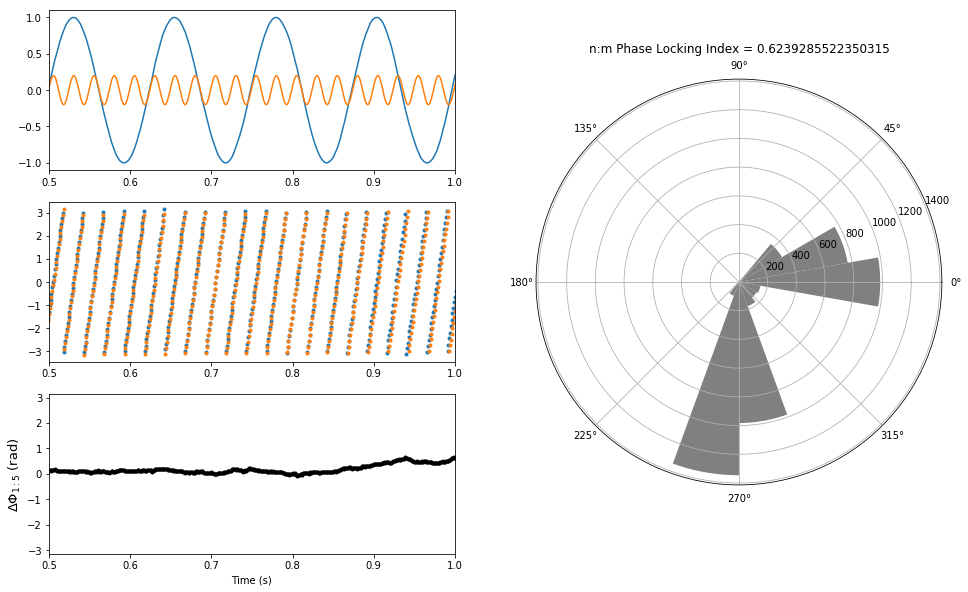

In [2]:
srate = 1000
dt = 1./srate
t = np.arange(0.,5.+dt/2,dt)

w = 2*np.pi*8+5*np.random.randn(len(t))
theta = np.sin(np.cumsum(w*dt))
w = 2*np.pi*40+5*np.random.randn(len(t))
gamma = 0.2*np.sin(np.cumsum(w*dt))

thetaphase = np.angle(hilbert(theta))
gammaphase = np.angle(hilbert(gamma))

m = 5
n = 1
Mthetaphase = np.angle(np.exp(1j*m*thetaphase))
Ngammaphase = np.angle(np.exp(1j*n*gammaphase))

plt.figure(figsize=(16,10))
plt.subplot(321)
plt.plot(t,theta)
plt.plot(t,gamma)
plt.xlim(0.5,1)

plt.subplot(323)
plt.plot(t,Mthetaphase,'.C0')
plt.plot(t,Ngammaphase,'.C1')
plt.xlim(0.5,1)

DeltaPhaseNM = np.angle(np.exp(1j*(Mthetaphase-Ngammaphase)))

plt.subplot(325)
plt.plot(t,DeltaPhaseNM,'.k')
plt.xlim(0.5,1)
plt.ylim(-np.pi,np.pi)
plt.ylabel('$\Delta\Phi_{1:5}$ (rad)',size=13)
plt.xlabel('Time (s)')

plt.subplot(122,polar=True)
nmPLV = abs(np.mean(np.exp(1j*DeltaPhaseNM)))
phasebincenters = np.arange(-170,171,20)
counts,phasebins = np.histogram(DeltaPhaseNM,np.deg2rad(phasebincenters))
plt.bar(phasebins[:-1]+np.deg2rad(10),counts,np.deg2rad(20),color='grey')
plt.title('n:m Phase Locking Index = '+str(nmPLV));

Finding best 'm':

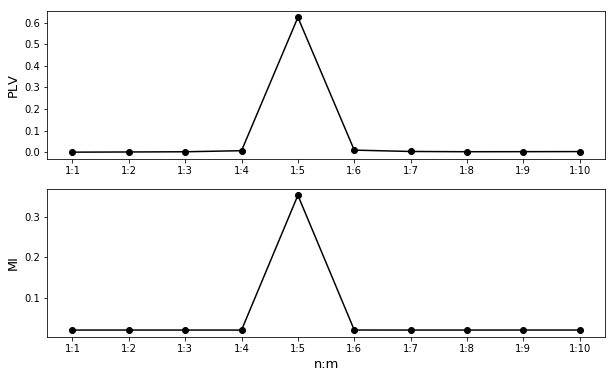

In [3]:
n = 1
nmPLV = []
label = []
nmMI  = []
phasebincenters = np.arange(-170,171,20)

for m in range(1,11):
    DeltaPhaseNM = np.angle(np.exp(1j*(m*thetaphase-n*gammaphase)))
    nmPLV.append(abs(np.mean(np.exp(1j*DeltaPhaseNM))))
    label.append('1:'+str(m))
    counts,phasebins = np.histogram(DeltaPhaseNM,np.deg2rad(phasebincenters))
    p = counts/float(sum(counts))
    H = -sum(p[p>0]*np.log(p[p>0]))
    Hmax = np.log(len(phasebins))
    nmMI.append((Hmax-H)/Hmax)

plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(range(1,11),nmPLV,'ko-')
plt.xticks(range(1,11),label)
plt.ylabel('PLV',size=13)

plt.subplot(212)
plt.plot(range(1,11),nmMI,'ko-')
plt.xticks(range(1,11),label)
plt.xlabel('n:m',size=13)
plt.ylabel('MI',size=13);

n:m phase-locking comodulogram:

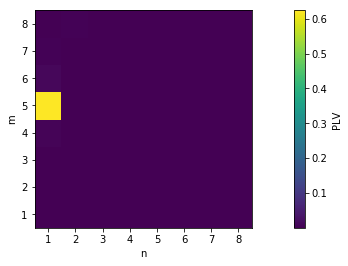

In [4]:
nmPLV = []
nmMI  = []

for n in range(1,9):
    for m in range(1,9):
        
        
        DeltaPhaseNM = np.angle(np.exp(1j*(m*thetaphase-n*gammaphase)))
        nmPLV.append(abs(np.mean(np.exp(1j*DeltaPhaseNM))))
        counts,phasebins = np.histogram(DeltaPhaseNM,np.deg2rad(phasebincenters))
        p = counts/float(sum(counts))
        H = -sum(p[p>0]*np.log(p[p>0]))
        Hmax = np.log(len(phasebins))
        nmMI.append((Hmax-H)/Hmax)
        
nmPLV = np.split(np.array(nmPLV),m)
nmMI = np.split(np.array(nmMI),m)

plt.pcolormesh(np.transpose(nmPLV))
plt.xlabel('n')
plt.ylabel('m')
plt.xticks(np.arange(0.5,8.5),range(1,9))
plt.yticks(np.arange(0.5,8.5),range(1,9))
plt.colorbar(label='PLV')
plt.axis('square');

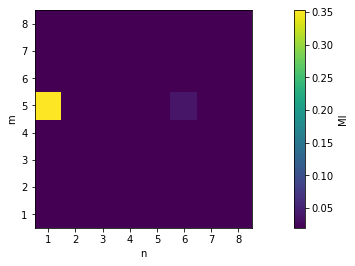

In [5]:
plt.pcolormesh(np.transpose(nmMI))
plt.xlabel('n')
plt.ylabel('m')
plt.xticks(np.arange(0.5,8.5),range(1,9))
plt.yticks(np.arange(0.5,8.5),range(1,9))
plt.colorbar(label='MI')
plt.axis('square');

Rayleigh test for non-uniformity:

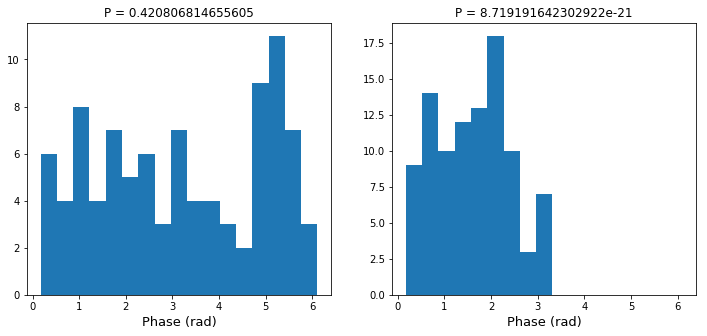

In [6]:
# non-coupled example
phi = np.random.rand(100)*2*np.pi

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(phi,np.deg2rad(np.arange(10,351,20)))
pval = rayleightest(phi)
plt.title('P = '+str(pval))
plt.xlabel('Phase (rad)',size=13)

# coupled example (non-uniform phase distribution)
phi = np.random.rand(100)*np.pi

plt.subplot(122)
plt.hist(phi,np.deg2rad(np.arange(10,351,20)))
pval = rayleightest(phi)
plt.title('P = '+str(pval))
plt.xlabel('Phase (rad)',size=13);

Remember that chance is still a thing is statistics:

In [7]:
PvalAll = np.empty(1000)
for nexp in range(1000):
    phi = np.random.rand(1000)*2*np.pi
    pval = rayleightest(phi)
    PvalAll[nexp] = pval

sum(PvalAll<0.05) # 5% of experiments and false positives

56

With real data:

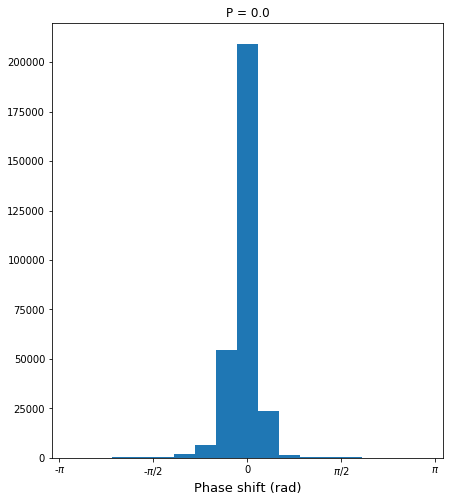

In [8]:
data = loadmat('LFP_HG_HFO.mat')
lfpHG = data['lfpHG'][0]
lfpHFO = data['lfpHFO'][0]

srate = 1000
dt = 1./srate
t = dt*(np.arange(len(lfpHG)))

order = 3
nyq = 0.5*srate
lowcut = 5./nyq
highcut = 10./nyq
b,a = butter(order,[lowcut,highcut],'bandpass')

filtered1 = filtfilt(b,a,lfpHG)
filtered2 = filtfilt(b,a,lfpHFO)

Phase1 = np.angle(hilbert(filtered1))
Phase2 = np.angle(hilbert(filtered2))

DeltaPhase = np.angle(np.exp(1j*(Phase1-Phase2)))

pval = rayleightest(DeltaPhase)

plt.figure(figsize=(7,8))
plt.hist(DeltaPhase,np.deg2rad(np.arange(-170,171,20)))
plt.xlabel('Phase shift (rad)',size=13)
plt.title('P = ' +str(pval))
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],['-$\pi$','-$\pi$/2',0,'$\pi$/2','$\pi$']);

Phase-Amplitude Coupling:

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


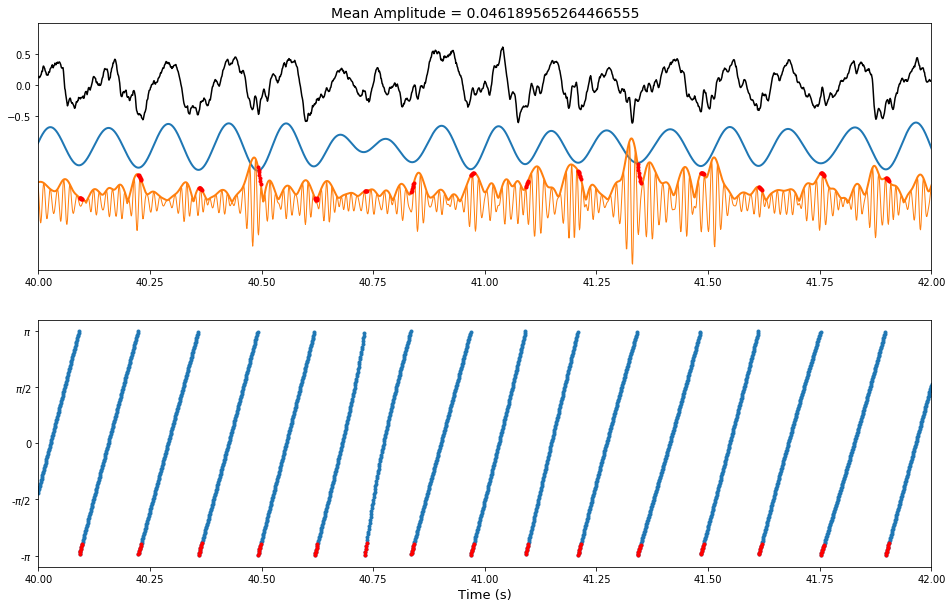

In [9]:
# Comparing phase and amplitude from two frequencies of the same signal
LFP = lfpHG

b,a = butter(3,[5./nyq,10./nyq],'bandpass')
filteredPhase = filtfilt(b,a,LFP)

b,a = butter(3,[60./nyq,100./nyq],'bandpass')
filteredAmp = filtfilt(b,a,LFP)

phase = np.angle(hilbert(filteredPhase))
amp = abs(hilbert(filteredAmp))

# Associated indices for each phase bin
I = (np.rad2deg(phase)>-180)*(np.rad2deg(phase)<-160)

plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(t,LFP,'k-')
plt.plot(t,filteredPhase-1,linewidth=2)
plt.plot(t,8*filteredAmp-1.9,linewidth=1)
plt.plot(t,8*amp-1.9,'C1',linewidth=2)
plt.xlim(40,42)
plt.ylim(-3,1)

plt.subplot(212)
plt.plot(t,phase,'C0.')
plt.plot(t[I],phase[I],'r.')
plt.xlim(40,42)
plt.xlabel('Time (s)',size=13)
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],['-$\pi$','-$\pi$/2',0,'$\pi$/2','$\pi$'])

plt.subplot(211)
plt.plot(t[I],8*amp[I]-1.9,'r.')
plt.yticks([-0.5,0,0.5])
plt.title('Mean Amplitude = '+str(np.mean(amp[I])),size=14);

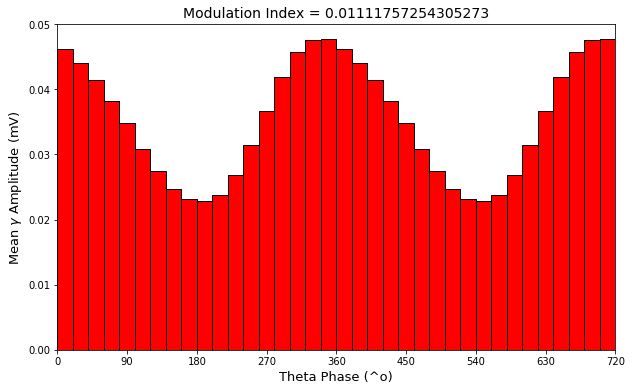

In [10]:
# Mean amplitude for each phase bin

phasevector = np.arange(-180,161,20)
MeanAmp = np.empty(len(phasevector))

for count,phasebin in enumerate(phasevector):
    I = (np.rad2deg(phase)>phasebin)*(np.rad2deg(phase)<phasebin+20)
    MeanAmp[count] = np.mean(amp[I])

plt.figure(figsize=(10,6))
plt.bar(np.arange(10,711,20),np.concatenate((np.array(MeanAmp),np.array(MeanAmp))),
        20,color='r',edgecolor='k')
plt.xticks(np.arange(0,721,90))
plt.xlabel('Theta Phase (^o)',size=13)
plt.ylabel('Mean $\gamma$ Amplitude (mV)',size=13)
plt.xlim(0,720)

# Entropy-based modulation index
p = MeanAmp/sum(MeanAmp)
H = -sum(p[p>0]*np.log(p[p>0]))
N = len(MeanAmp)
MI = (np.log(N)-H)/np.log(N)
plt.title('Modulation Index = '+str(MI),size=14);

In [11]:
# Phase-Amplitude comodulogram
LFP = lfpHG

phase_freq_vector = np.arange(1.,20.,2.)
fp_bandwidth = 4
amp_freq_vector = np.arange(20.,201.,5.)
fa_bandwidth = 10

MeanAmp = np.empty(len(phasevector))
Comodulogram = np.empty((len(phase_freq_vector),len(amp_freq_vector)))

for count_phase,fp in enumerate(phase_freq_vector):
    b,a = butter(3,[fp/nyq,(fp+fp_bandwidth)/nyq],'bandpass')
    filteredPhase = filtfilt(b,a,LFP)
    phase = np.angle(hilbert(filteredPhase))
        
    for count_amp,fa in enumerate(amp_freq_vector):
        b,a = butter(3,[fa/nyq,(fa+fa_bandwidth)/nyq],'bandpass')
        filteredAmp = filtfilt(b,a,LFP)
        amp = abs(hilbert(filteredAmp))
        
        for count,phasebin in enumerate(phasevector):
            I = (np.rad2deg(phase)>phasebin)*(np.rad2deg(phase)<(phasebin+20))
            MeanAmp[count] = np.mean(amp[I])

        p = MeanAmp/sum(MeanAmp)
        MI = (np.log(len(p))+sum(p[p>0]*np.log(p[p>0])))/np.log(len(p))
        Comodulogram[count_phase,count_amp] = MI

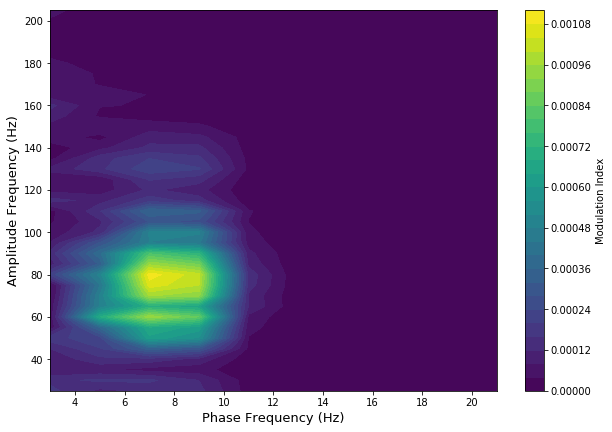

In [12]:
plt.figure(figsize=(10,7))
plt.contourf(phase_freq_vector+fp_bandwidth/2.,amp_freq_vector+fa_bandwidth/2.,Comodulogram.T,30)
plt.xlabel('Phase Frequency (Hz)',size=13)
plt.ylabel('Amplitude Frequency (Hz)',size=13)
plt.colorbar(label="Modulation Index");

<br>
- Amplitude-Amplitude Coupling

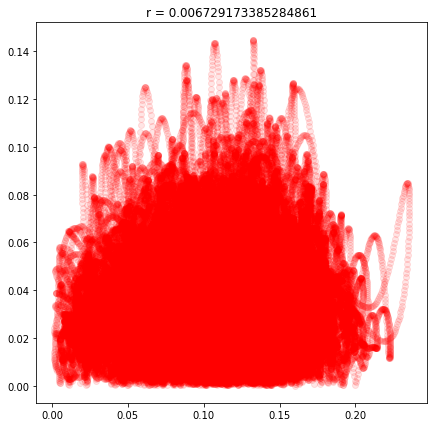

In [13]:
b,a = butter(3,[5./nyq,10./nyq],'bandpass')
filtered1 = filtfilt(b,a,lfpHFO)

b,a = butter(3,[30./nyq,50./nyq],'bandpass')
filtered2 = filtfilt(b,a,lfpHFO)

amp1 = abs(hilbert(filtered1))
amp2 = abs(hilbert(filtered2))

plt.figure(figsize=(7,7))
plt.plot(amp1,amp2,'ro',alpha=0.1)
r = np.corrcoef(amp1,amp2)
plt.title('r = '+str(r[0,1]));

In [14]:
from scipy.stats.stats import pearsonr
r,p = pearsonr(amp1,amp2)
print r

0.006729173385284844


In [15]:
# Amplitude-Amplitude comodulogram
ampfreqvector1 = np.arange(5.,101.,5.)
ampfreqvector2 = np.arange(5.,101.,5.)
Comodulogram = np.empty((len(ampfreqvector1),len(ampfreqvector2)))
ampbandwidth = 10.

for count1,fa1 in enumerate(ampfreqvector1):
    b,a = butter(3,[fa1/nyq,(fa1+ampbandwidth)/nyq],'bandpass')
    filtered1 = filtfilt(b,a,lfpHFO)
    amp1 = abs(hilbert(filtered1))
    
    for count2,fa2 in enumerate(ampfreqvector2):
        b,a = butter(3,[fa2/nyq,(fa2+ampbandwidth)/nyq],'bandpass')
        filtered2 = filtfilt(b,a,lfpHFO)
        amp2 = abs(hilbert(filtered2))

        r,p = pearsonr(amp1,amp2)
        Comodulogram[count1,count2] = r

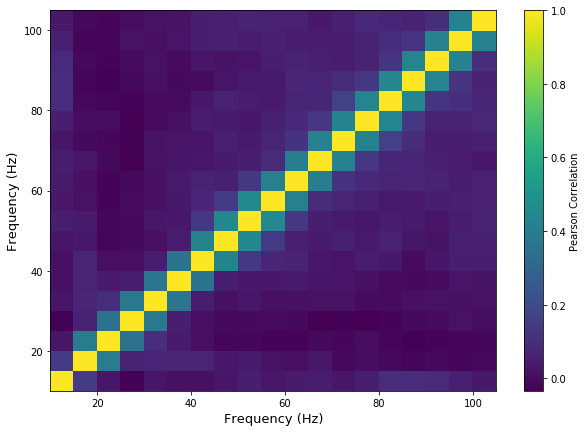

In [16]:
plt.figure(figsize=(10,7))
plt.pcolormesh(ampfreqvector1+ampbandwidth/2,ampfreqvector2+ampbandwidth/2,Comodulogram)
plt.xlabel('Frequency (Hz)',size=13)
plt.ylabel('Frequency (Hz)',size=13)
plt.colorbar(label='Pearson Correlation');

In [17]:
# Amplitude-Amplitude comodulogram
# via Power correlations

F,T,TFD_HG = spectrogram(lfpHG,srate,nperseg=4*int(srate))#,[],5000)
F,T,TFD_HFO = spectrogram(lfpHFO,srate,nperseg=4*int(srate))#,[],5000)
bandwidth = 10.
ampfreq = np.arange(1.,200.)
Comodulogram = np.empty((len(ampfreq),len(ampfreq)))

for count1,fa1 in enumerate(ampfreq):
    I1 = (F>fa1)*(F<(fa1+bandwidth))
    power1 = np.mean(TFD_HG[I1],axis=0)

    for count2,fa2 in enumerate(ampfreq):
        I2 = (F>fa2)*(F<(fa2+bandwidth))
        power2 = np.mean(TFD_HG[I2],axis=0)
#         power2 = np.mean(TFD_HFO[I2],axis=0) #cross-regional
        r,p = pearsonr(power1,power2)
        Comodulogram[count1,count2] = r

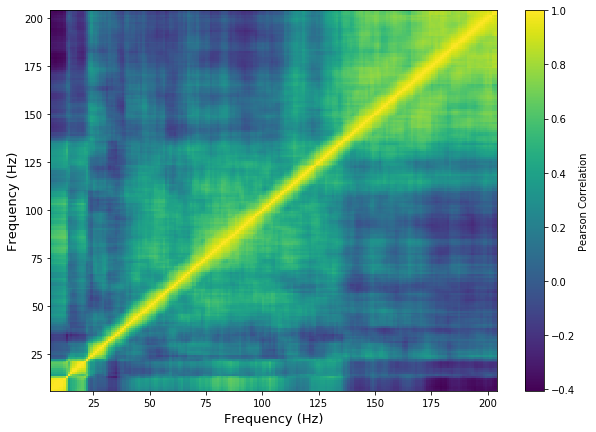

In [18]:
plt.figure(figsize=(10,7))
plt.pcolormesh(ampfreq+bandwidth/2,ampfreq+bandwidth/2,Comodulogram)
plt.xlabel('Frequency (Hz)',size=13)
plt.ylabel('Frequency (Hz)',size=13)
plt.colorbar(label='Pearson Correlation');